# Latent Semantic Analysis (LSA)

Use SVD for dimensionality reduction. 

Point of departure: [Analytics Vidhya Tutorial](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/). 

Consulted Prof. Steve Brunton's [YouTube lecture series](https://www.youtube.com/playlist?list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv) and [Data-Driven Science and Engineering book](https://www.amazon.com/Data-Driven-Science-Engineering-Learning-Dynamical/dp/1108422098) - see notes from first few lectures [here](Extra_SteveBrunton_SVD_lecture.pdf).


---

### Setup

In [1]:
import os
import time
import json

import numpy as np
import pandas as pd

import urlextract
from datetime import datetime
from nltk.stem import WordNetLemmatizer

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-06


### Load Data

In [2]:
# load X, y train subsets
raw_path = os.path.join("..","data","1_raw")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

# create arrays
X_array = np.array(X_train.iloc[:,0]).ravel()
y_array = np.array(y_train.iloc[:,0]).ravel()

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

### BoW and Tfidf

Here I clean and preprocess the data in two formats, a Bag-of-(upto)-Bigrams with 2,000 terms, and a Tfidf representation of the same.

In [3]:
# custom module
import cleanup_module as Cmod

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

url_extractor = urlextract.URLExtract()
lemmatizer = WordNetLemmatizer()

pipe = Pipeline([('counter', Cmod.DocumentToNgramCounterTransformer(n_grams=2)),
                 ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))                  
                ])

In [4]:
# BoW
X_trans_counter = pipe['counter'].fit_transform(X_array)
X_trans_bow = pipe['bow'].fit_transform(X_trans_counter) 

# Tfidf
X_trans_tfidf = pipe.fit_transform(X_array)

In [5]:
# convert to fptype for SVD
X_trans_bow = X_trans_bow.asfptype()

### SVD

Borroming from sklearn's **TruncatedSVD** class, "arpack" algorithm (the "randomized" algorithm takes longer and arrives at the same result), here are the relevant code bits:

[(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/decomposition/_truncated_svd.py#L24)
```
149    def fit_transform(self, X, y=None):
[...]
168        if self.algorithm == "arpack":
169             U, Sigma, VT = svds(X, k=self.n_components, tol=self.tol)
170             # svds doesn't abide by scipy.linalg.svd/randomized_svd
171             # conventions, so reverse its outputs.
172            Sigma = Sigma[::-1]
173            U, VT = svd_flip(U[:, ::-1], VT[::-1])
```                                          

In [5]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

U, Sigma, VT = svds(X_trans_tfidf.T, # transposed to a term-document matrix
                    k=300) # k = number of components / "topics"
# reverse outputs
Sigma = Sigma[::-1]
U, VT = svd_flip(U[:, ::-1], VT[::-1])

In [6]:
U.shape, Sigma.shape, VT.shape

((2001, 300), (300,), (300, 3900))

In [7]:
V = VT.T
V.shape, y_array.shape

((3900, 300), (3900,))

- U contains the eigenvectors of the term correlations: $XX^T$
- V contains the eigenvectors of the document correlations: $X^TX$
- $\Sigma$ contains the singular values of the factorization

### SVD Tfidf

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, V, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


accuracy: 0.8674 (+/- 0.0006)


### Original Tfidf

In [9]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_trans_tfidf, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


accuracy: 0.9769 (+/- 0.0040)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


### SVD bow

In [11]:
# convert to fptype for SVD
X_trans_bow = X_trans_bow.asfptype()

U, Sigma, VT = svds(X_trans_bow.T, # transposed to a term-document matrix
                    k=300) # k = number of components / "topics"
# reverse outputs
Sigma = Sigma[::-1]
U, VT = svd_flip(U[:, ::-1], VT[::-1])

# transpose VT
V = VT.T

In [12]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, V, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy: 0.8674 (+/- 0.0006)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


### Original bow

In [13]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_trans_bow, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

accuracy: 0.9851 (+/- 0.0041)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


### Plotting singular values


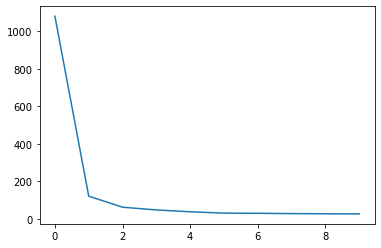

In [14]:
import matplotlib.pyplot as plt

plt.plot(Sigma[:10])
plt.show()

---

**Final Notes**

Avoiding Naive Bayes on SVD since it implies strong independence between variables.

Quoting the [Analytics Vidhya Tutorial](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/) ~

"*Apart from LSA, there are other advanced and efficient topic modeling techniques such as Latent Dirichlet Allocation (LDA) and lda2Vec. We have a wonderful article on LDA which you can check out [here](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/). lda2vec is a much more advanced topic modeling which is based on word2vec word embeddings.*"

In [15]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 11 m 15 s
